In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, vmap, config, device_put
import jax
import jaxquantum as jqt
import jax.numpy as jnp
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

# gpu_device = jax.devices('gpu')[0]
cpu_device = jax.devices('cpu')[0]

In [3]:

def simulate(initial_state):
    # Operators and States ----
    Na = device_put(20)
    a = jqt.destroy(Na)
    adag = jqt.create(Na)

    # Parameters ----
    K = device_put(2*jnp.pi*20e-3) # [GHz]
    alpha = device_put(1.5)
    eps_2 = alpha**2 * K
    delta = 0 * K

    # Hamiltonian ----

    def squeezing_drive(t):
        return eps_2 * jnp.tanh((2*K/10) * t)

    def Ht(t):
        return delta * adag @ a + -K * adag @ adag @ a @ a + squeezing_drive(t) * (adag @ adag + a @ a)

    # Loss ----
    kappa = 1e-3 # [GHz]
    c_ops = []#kappa * a]

    # Simulation controls ----
    ts = jnp.linspace(0,1e3,101) # [ns]
    
    states = jqt.mesolve(initial_state, ts, Ht=Ht, c_ops=[]) 
    # states = jqt.sesolve(initial_state, ts, Ht=Ht) 

    return states

In [4]:
with jax.default_device(cpu_device):
    %timeit -n1 -r1 states = simulate(jqt.basis(20, 0).to_dm())

100% |██████████| [00:04<00:00, 23.21%/s] 


5.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
with jax.default_device(gpu_device):
    %timeit -n1 -r1 states = simulate(jqt.basis(20, 0))

/home/shanj/miniconda3/envs/jax-new/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


7.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
with jax.profiler.trace("/tmp/tensorboard"):
    with jax.default_device(gpu_device):
        states = simulate(jqt.basis(20, 1))
        states[0].data.block_until_ready()

2024-05-26 19:40:30.933905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/shanj/miniconda3/envs/jax-new/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


100% |██████████| [00:04<00:00, 24.22%/s] 


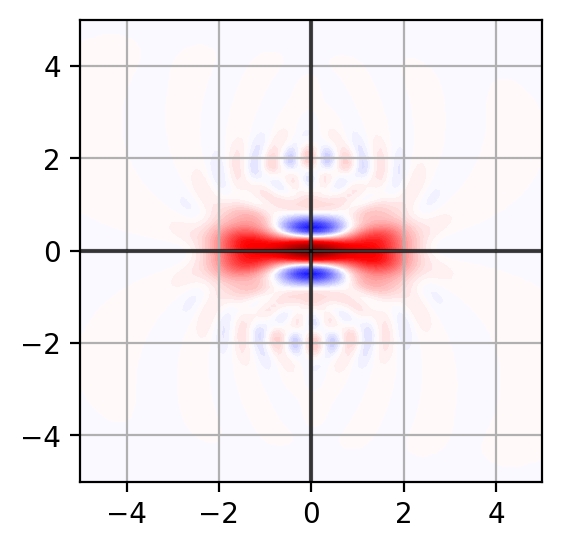

In [5]:
with jax.default_device(cpu_device):
    pts = jnp.linspace(-5,5,101)
    states = simulate(jqt.basis(20, 0))
    jqt.plot_wigner(jqt.ptrace(states[-1], 0), pts=pts)